<a href="https://colab.research.google.com/github/abymmathew/self-learning-tutorial-sp24-50573/blob/main/self_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self Learning Tutorial Fine Tuning BERT for NER Task
**SDoH Terms Extraction**

## Introduction

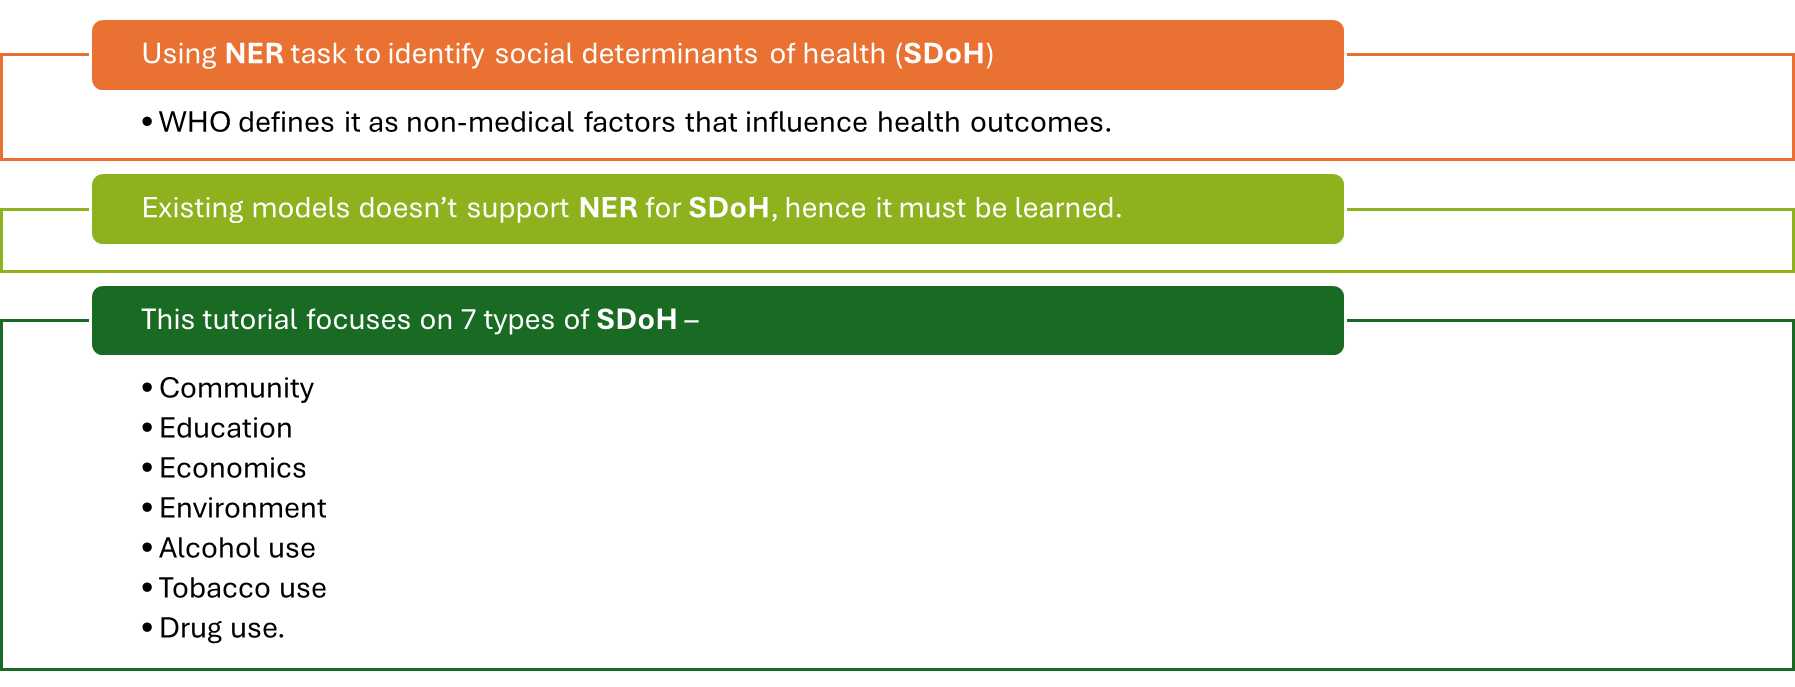

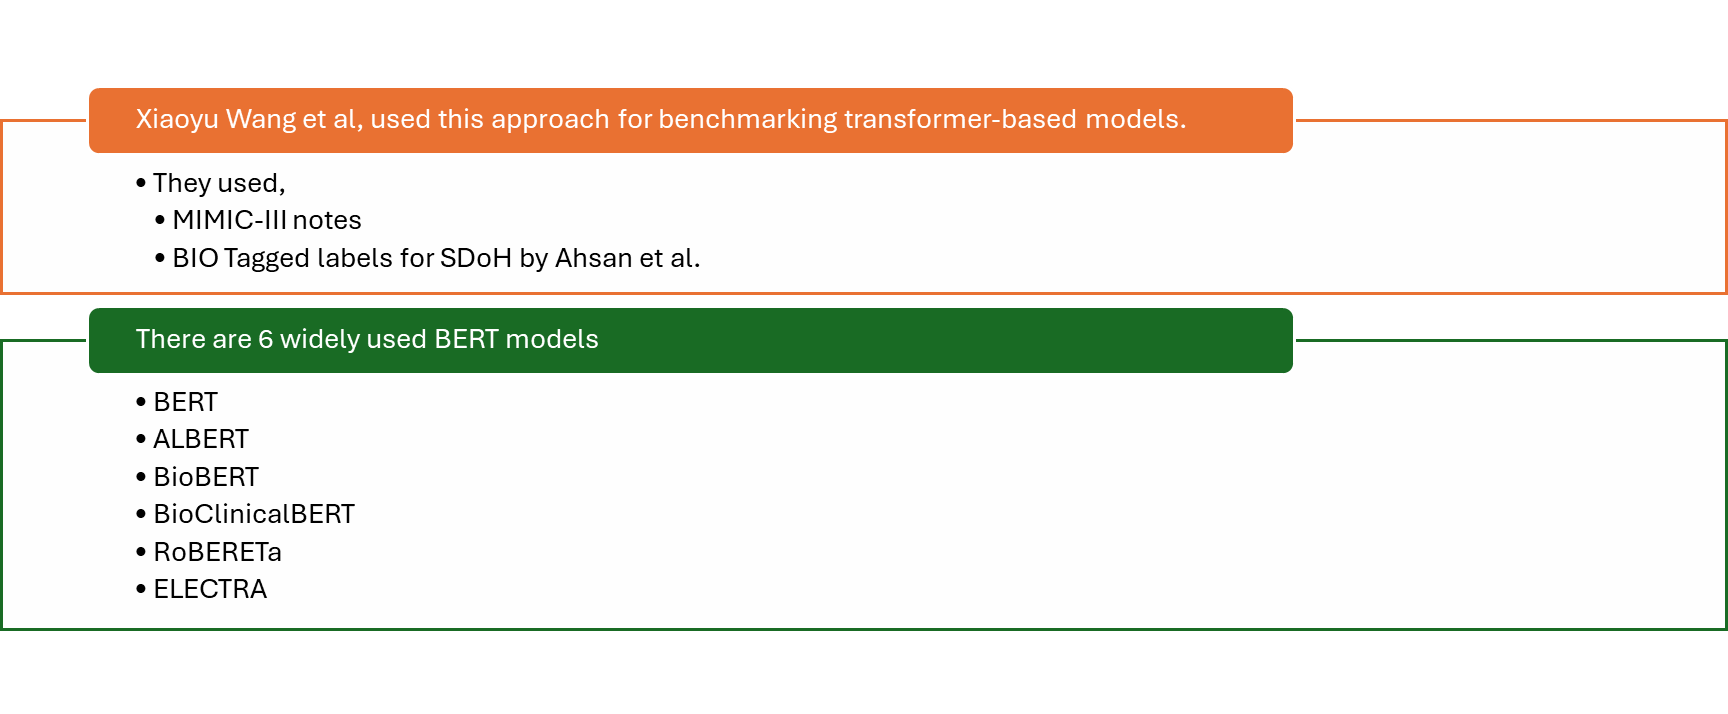

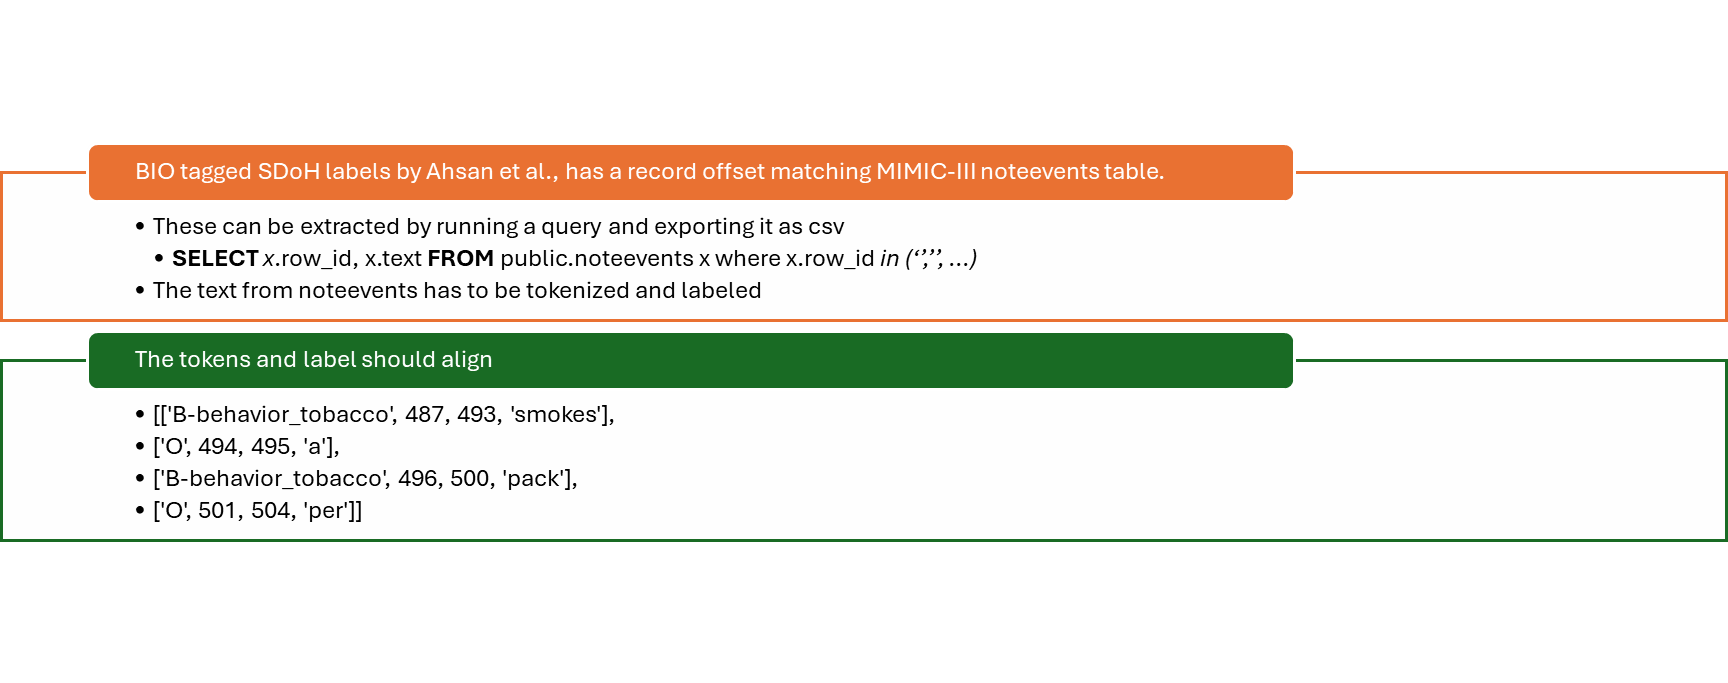

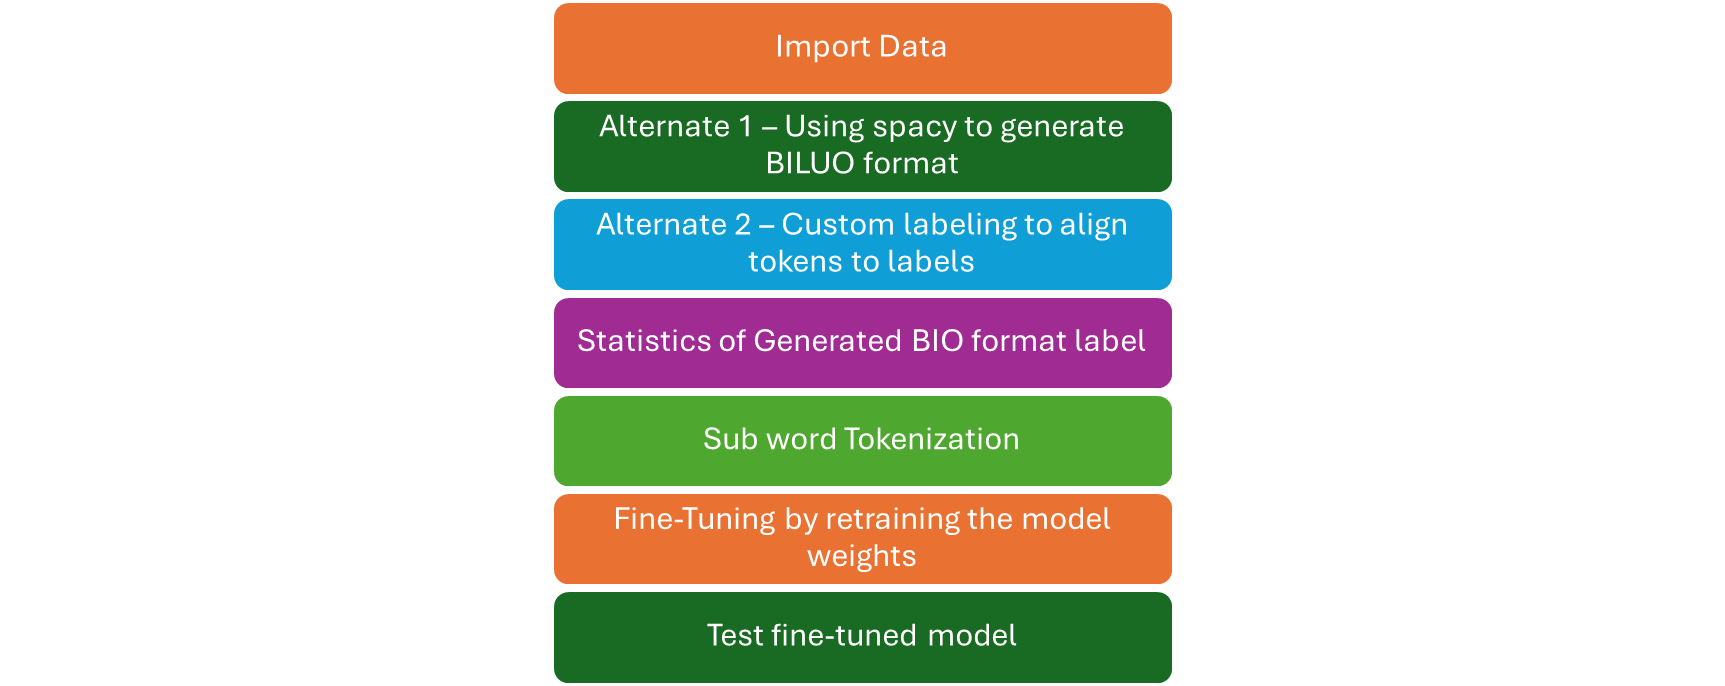

# Import Data
Two CSV FILES need to be imported,


1.   Annotation file - containing BIO formatted SDoH terms with token offset matching noteevents text.
2.   Text file - contains all the noteevents represented in annotation file.

Reference for this process - [Benchmarking Transformer-Based Models for Identifying Social
Determinants of Health in Clinical Notes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10795706/pdf/nihms-1957582.pdf)



In [58]:
!wget -q --show-progress --no-check-certificate 'https://github.com/abymmathew/self-learning-tutorial-sp24-50573/raw/main/text.7z' -O text.7z
!wget -q --show-progress --no-check-certificate 'https://github.com/abymmathew/self-learning-tutorial-sp24-50573/raw/main/annotations.csv' -O annotations.csv
!7z x /content/text.7z -y


text.7z             100%[===================>]  14.33M  36.8MB/s    in 0.4s    
annotations.csv     100%[===================>]   1.09M  5.74MB/s    in 0.2s    

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 15031412 bytes (15 MiB)

Extracting archive: /content/text.7z
--
Path = /content/text.7z
Type = 7z
Physical Size = 15031412
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%     19% - text.csv                44% - text.csv                66% - text.csv                88% - text.csv               Everything is Ok

Size:       76222215
Compressed: 15031412


In [59]:
import csv

def generate_annotated_csv(annotations_file, text_file, output_file):
  """
  Generates a CSV file with "label,annotation" columns based on annotations and text files.

  Args:
      annotations_file: Path to the CSV file containing annotations (row_id, sbdh, start, end).
      text_file: Path to the CSV file containing text (row_id, text).
      output_file: Path to the output CSV file (label, annotation).
  """
  annotations = {}
  texts = {}

  # Read annotations file
  with open(annotations_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      row_id = row["row_id"]
      annotations.setdefault(row_id, []).append({
          "sbdh": row["sbdh"],
          "start": int(row["start"]),
          "end": int(row["end"])
      })

  # Read text file
  with open(text_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      row_id = row["row_id"]
      texts[row_id] = row["text"]

  # Combine annotations and text, write to output file
  with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["rowid","label","start","end","annotation"])
    for row_id, text in texts.items():
      if row_id not in annotations:
        continue  # Skip rows without annotations
      for annotation in annotations[row_id]:
        start, end = annotation["start"], annotation["end"]
        if start >= 0 and end <= len(text):  # Check for valid indices
          annotation_text = text[start:end]
          writer.writerow([row_id, annotation["sbdh"], start, end, annotation_text])



In [60]:
annotations_file = "/content/annotations.csv"
text_file = "/content/text.csv"
annotated_file = "/content/annotated.csv"

generate_annotated_csv(annotations_file, text_file, annotated_file)
print(f"Annotated CSV file created: {annotated_file}")

Annotated CSV file created: /content/annotated.csv


In [61]:
annotated = {}
# Read annotations file
with open(annotated_file, newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  for row in reader:
    row_id = row["rowid"]
    annotated.setdefault(row_id, []).append({
        "label": row["label"],
        "start": int(row["start"]),
        "end": int(row["end"]),
        "annotation": row["annotation"]
    })

print(annotated)

{'5': [{'label': 'behavior_tobacco', 'start': 534, 'end': 540, 'annotation': 'smokes'}, {'label': 'behavior_tobacco', 'start': 543, 'end': 547, 'annotation': 'pack'}], '6': [{'label': 'sdoh_environment', 'start': 1002, 'end': 1007, 'annotation': 'Lives'}, {'label': 'sdoh_community', 'start': 1013, 'end': 1017, 'annotation': 'Wife'}], '12': [{'label': 'sdoh_economics', 'start': 1070, 'end': 1077, 'annotation': 'Retired'}, {'label': 'sdoh_community', 'start': 1184, 'end': 1192, 'annotation': 'Daughter'}, {'label': 'behavior_tobacco', 'start': 1203, 'end': 1210, 'annotation': 'Tobacco'}, {'label': 'behavior_alcohol', 'start': 1217, 'end': 1221, 'annotation': 'ETOH'}], '22': [{'label': 'sdoh_environment', 'start': 1992, 'end': 1997, 'annotation': 'rehab'}, {'label': 'behavior_alcohol', 'start': 2160, 'end': 2167, 'annotation': 'alcohol'}], '27': [{'label': 'behavior_tobacco', 'start': 853, 'end': 858, 'annotation': 'packs'}, {'label': 'sdoh_environment', 'start': 821, 'end': 829, 'annotati

In [62]:
#
# annotations that contained tokens with line feed, that is not used in the training.
# The original authors of the SDoH labels, kept new line characters intact. This was kept here for future purpose to evaluating the model with line feeds (LF).
#
result_tuples = [(key, d['annotation']) for key, value in annotated.items() for d in value]
for key, value in result_tuples:
  if '\n' in value:
    print(key, value)

65 eighth-grade
education
614 illicit
drug
762 intravenous
drug
1090 high
school
2226 illicit
drug
2229 illicit
drugs
2369 illicit
substances
5690 retirement
community
6279 nursing
home
6394 illicit
drugs
7524 alcoholic
drinks
7762 intravenous
drug
7775 4th
grade
7776 4th
grade
8651 illicit
drug
8714 illicit
substances
8878 illicit
drug
8879 illicit
drug
8889 illicit
drugs
8890 illicit
drugs
9763 alcoholic
beverages
9987 illict
drugs
10165 illicit
drug
10255 nursing
home staff
11998 illicit
drug
12010 illicit
drugs
12953 illicit
drugs
13006 Competetive ballroom
dancer
13175 Retirement
Community
13227 illicit
drug
13460 illicit
drugs
14426 intravenous
drug
14496 high
school
16204 intravenous
drug
16395 alcoholic
beverage
17885 by
himself
18888 step-
parents
20284 alcoholic
drinks
21861 medical
degree
21921 alcoholic
drinks
22048 intravenous
drug
22080 illicit
drugs
22572 illicit
drugs
23378 alcoholic
drinks/week
23549 illicit
drug
24021 illicit IV
drug
24728 5th grade
teacher
25788 ment

# Alternate 1 - Tokenize using spacy to generate BILUO format
This was a first attempt to tokenize with Spacy's technique. The process is designed for tokenizing large corpuses. However its not robust from what I learnt. Tokens can get misaligned with labels in the process and hence the training of the model will also be affected.

**Note**: This is an artifact that was created during the first iteration. Ignore this if not required. It won't affect the process.

In [63]:
%pip install spacy

In [64]:
#
# Approach #1, to get BIO token format.
# Alternate approach, the tokenization process used to generate offsets that are not aligned
# Spacy based tokenizer to generate BILUO format
#

from logging import debug
import spacy
import csv
import re
import warnings
from spacy.training import offsets_to_biluo_tags
from spacy.training import biluo_tags_to_spans
from spacy.symbols import ORTH
from spacy.tokenizer import Tokenizer
from collections import defaultdict


infix_re = re.compile(r"^-[^ ]+")

def custom_tokenizer(nlp):
  return Tokenizer(nlp.vocab,infix_finditer=infix_re.finditer)

nlp = spacy.load("en_core_web_sm")
#nlp.tokenizer = custom_tokenizer(nlp)

texts = {}
annotations={}

 # Read annotations file
with open('/content/annotations.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    group_id=1
    current_row_id = None
    for row in reader:
      row_id = row["row_id"]

      if row_id != current_row_id:
      # New rowid, start a new group
        current_row_id = row_id
        group_id += 1

      annotations.setdefault(row_id, []).append({
          "sbdh": row["sbdh"],
          "start": int(row["start"]),
          "end": int(row["end"]),
          "group_id": group_id
      })

with open('/content/text.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    group_by_rowid = lambda csv_data: [data for rowid, data in defaultdict(list).items(csv_data)]

    for row in reader:
      row_id = row["row_id"]
      texts[row_id] = {"text" : row["text"], "tags":[]}

      if row_id not in annotations:
        continue  # Skip rows without annotations
      #for annotation in annotations[row_id]:
      texts[row_id]['tags'] = [[int(item['start']), int(item['end']), item['sbdh'], int(item['group_id'])] for item in annotations[row_id]]

group_by_last_column = lambda data: {key: [d for d in data if d[-1] == key] for key in set(d[-1] for d in data)}

#debug
debug = False
record_list = [188]

with open("/content/output.csv", "w", newline="") as csvfile:
  writer = csv.writer(csvfile)
  # Write the header row
  writer.writerow(["row_id", "tags", "end", "begin"])

  for row_id, data in texts.items():
    if debug:
      if int(row_id) not in record_list:
        continue

    grouped_data = group_by_last_column(data['tags'])

    for key, group in grouped_data.items():
      unique_group = list(set(tuple(row) for row in group))
      start, end, label, group = zip(*unique_group)

      minimum_value  = min(start+end)
      maximum_value = max(start+end)

      updated_unique_group = [(int(x)-0, int(y)-0, z, v) for (x, y, z, v) in unique_group]

      try:
        doc = nlp.make_doc(data['text'][0:maximum_value+25])
        tags = offsets_to_biluo_tags(doc, [row[:-1] for row in updated_unique_group])
        if debug:
          #print(row_id, data['text'][0:maximum_value])
          print(row_id)
          print(doc.ents)
          print(tags)
        else:
          print(row_id)
          writer.writerow([row_id, ",".join(tags), maximum_value+25, 0])
      except Warning:
        print(f"Group {key}:", group)
        continue


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


5
6
12
22
27
34
38
41
42
65
70
73
75
84
89
91
96
98
101
107
111
123
129
130
136
146
150
164
178
188
189


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2198-7-17**]              Disc..." with entities "[(2010, 2014, 'behavior_alcohol'), (2038, 2044, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


193
198
201
211
213
227
235
281
285
290
295
302
315
316
317
323
328
332
343
357
365
376
381
386
387
390
392
410
416
418
420


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2167-3-12**]              Disc..." with entities "[(2336, 2340, 'sdoh_community'), (2298, 2305, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


422
436
442
451
453
467
471
486
488
493
512
513
520
522
536
542
564
581
614
615
619
632
638
640
647
671
687
701
702
706
720
721
725
734
735
757
761
762
781
787
794
798
815
824
828
834
835
851
860
865
871
877
881
899
906
909
921
936
937
948
961
969
975
976
981
990
993


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2155-8-3**]              Disch..." with entities "[(2285, 2294, 'sdoh_economics'), (2310, 2317, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


999
1014
1015
1021
1022
1039
1040
1043
1046
1053
1054
1057
1060
1061
1065
1068
1073
1090
1095
1123
1145
1152
1153
1165
1168
1169
1176
1186
1203
1213
1222
1230
1232
1238
1260
1262
1269
1294
1297
1307
1308
1321
1328
1341
1342
1346
1357
1363
1372
1375
1376
1385
1386
1401
1404
1413
1416
1423
1424
1426
1429
1430
1442
1447
1448
1449
1454
1455
1457
1483
1484
1487
1488
1490
1497
1507
1508
1509
1523
1546
1556
1558
1571
1575
1583
1588
1597
1625
1628
1631
1635
1657
1658
1659
1660
1676
1695


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2120-1-5**]              Disch..." with entities "[(2784, 2792, 'behavior_alcohol'), (2761, 2768, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2153-9-15**]              Disc..." with entities "[(3124, 3131, 'sdoh_community'), (3140, 3154, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


1702
1706
1708
1716
1723
1728
1807
1820
1825
1826
1836
1850
1855
1858
1863
1867
1868
1869
1870
1871
1872
1877
1881
1883
1884
1903
1905
1908
1933
1934
1938
1940
1941
1945
1946
1949
1987
1996
1998
2000
2002
2003
2004
2014
2076
2086
2169
2175
2177
2181
2183
2184
2186
2187
2188
2190
2193
2194
2195
2196
2197
2199
2201
2202
2204
2205
2209
2210
2211
2212
2215
2216
2217
2218
2219
2221
2222
2224
2225
2225
2226
2227
2228
2229
2230
2231
2292
2304
2306
2309
2312
2313
2314
2315
2316
2317
2319
2321
2326
2327
2328
2329
2330
2331
2332
2333
2335
2336
2337
2338
2340
2342
2344
2367
2369
2378
2426
2429
2435
2439
2441
2442
2443
2444
2445
2446
2447
2448
2449
2452
2455
2456
2457
2458
2462
2467
2499
2574
2585
2599
2633
2712
2713
2714
2715
2716
2717
2718
2719
2722
2723
2724
2725
2728
2766
2777
2826
2828
2876
2883
2945
2976
2979
3023
3025
3026
3040
3149
3150
3154
3225
3226
3227
3228
3229
3230
3231
3232
3233
3293
3329
3341
3356
3382
3426
3432
3464
3480


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2177-9-22**]              Disc..." with entities "[(1567, 1572, 'sdoh_environment'), (1578, 1582, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2122-6-30**]              Disc..." with entities "[(2794, 2801, 'behavior_tobacco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


3488
3491
3565
3639
3646
3679
3815
3830
3884
3893
3897
3909
3947
4014
4041
4215
4221
4248
4315
4323
4396
4411
4424
4430
4454
4518
4520
4523
4539
4546
4563
4574
4617
4620
4630
4715
4800
4812
4914
4926
5001
5029
5048
5136
5158
5178
5199
5208
5297
5300
5353
5356
5373
5394
5395


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2159-7-22**]              Disc..." with entities "[(2392, 2396, 'behavior_alcohol'), (1977, 1985, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2175-9-11**]              Disc..." with entities "[(2656, 2668, 'behavior_drug'), (2546, 2553, 'beha...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


5413
5448
5520
5521
5524
5526
5527
5532
5534
5539
5540
5541
5542
5544
5545
5548
5549
5550
5551
5552
5553
5553
5554
5555
5556
5557
5558
5559
5562
5563
5564
5565
5566
5569
5571
5572
5573
5574
5576
5578
5579
5580
5582
5583
5585
5586
5587
5588
5590
5592
5594
5595
5597
5598
5599
5601
5603
5605
5606
5607
5608
5609
5612
5640
5641
5643
5644
5648
5649
5650
5651
5652
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5672
5676
5677
5678
5683
5684
5685
5686
5686
5687
5688
5689
5690
5691
5692
5693
5716
5717
5729
5730
5731
5733
5745
5760
5763
5764
5770
5798
5808
5827
5905
5917
5921


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2146-7-17**]              Disc..." with entities "[(2913, 2917, 'sdoh_economics'), (2893, 2900, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


5922
5925
5926
5927
5928
5929
5931
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5947
5948
5949
5950
5967
5980
6001
6115
6116
6117
6118
6119
6140
6149
6160
6162
6163
6164
6166
6168
6169
6170
6171
6172
6173
6174
6175
6178
6179
6180
6181
6183
6184
6186
6188
6189
6190
6191
6223
6247
6248
6249
6250
6255
6259
6265
6267
6267
6269
6271
6271
6272
6275
6276
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6311
6323
6326
6379
6382
6383
6385
6389
6392
6393
6394
6395
6396
6397
6398
6401
6402
6413
6427
6429
6431
6435
6436
6440
6447
6467
6486
6488
6489
6496
6498
6519
6519
6533
6538


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2113-2-28**]              Disc..." with entities "[(1193, 1198, 'sdoh_environment'), (1478, 1484, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2200-3-12**]              Disc..." with entities "[(2968, 2972, 'behavior_tobacco'), (3082, 3090, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


6611
6612
6613
6614
6616
6617
6651
6654
6671
6673
6685
6689
6699
6821
6834
6835
6836
6842
6843
6857
6864
6866
6867
6868
6869
6870
6872
6873
6874
6875
6876
6877
6878
6879
6880
6893
6927
6952
6955
6957
6958
6959
6960
6962
6963
6965
6966
6967
6968
7005
7032
7039
7048
7060
7065
7067
7078
7081
7082
7106
7129
7130
7132
7133
7135
7137
7138
7139
7140
7141
7142
7144
7145
7146
7147
7148
7149
7150
7152
7153
7154
7155
7156
7157
7158
7159
7160
7162
7163
7164
7165
7166
7167
7174
7176
7178
7179
7180
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7193
7194
7195
7198
7199
7200
7249
7269
7279
7291
7354
7371
7373
7382
7385
7389
7391
7460
7468
7486
7489
7505
7523
7524
7536
7543
7554
7562
7568
7663
7668
7669
7677
7679
7690
7694
7696
7725
7728
7745
7746
7747


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2153-6-20**]              Disc..." with entities "[(2403, 2413, 'sdoh_economics'), (2416, 2423, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


7748
7749
7750
7751
7751
7752
7753
7754
7755
7757
7758
7758
7760
7761
7762
7764
7765
7767
7768
7769
7770
7772
7773
7775
7776
7777
7779
7794
7819
7823
7824
7825
7828
7829
7830
7831
7832
7836
7837
7838
7839
7840
7842
7845
7846
7847
7849
7850
7851
7870
7872
7873
7874
7875
7876
7878
7880
7883
7884
7885
7886
7890
7892
7894
7895
7896
7897
7897
7898
7899
7900
7901
7923
7953
7970
7972
7973
7974
7975
7976
7977
7981
7983
7984
7985
7987
7989
7991
7992
7994
7995
7996
7997
7999
8000
8003
8004
8006
8008
8009
8010
8034
8038
8038
8068
8070
8072
8073
8074
8079
8083
8085
8086
8086
8087
8089
8091
8107
8123
8134
8175
8176
8179
8181
8182
8183
8210
8245
8260
8287
8317
8322
8359
8360
8361
8362
8363
8410
8455
8465
8466
8492
8549
8557
8602
8604
8608
8617
8626
8651
8655
8683
8691
8705
8706
8707
8709


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2177-7-23**]              Disc..." with entities "[(1852, 1865, 'sdoh_community'), (1953, 1956, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


8710
8712
8713
8714
8715
8716
8717
8717
8718
8732
8766
8768
8769
8778
8842
8853
8870
8871
8872
8873
8875
8877
8878
8879
8880
8883
8884
8885
8886
8887
8888
8889
8890
8892
8894
8895
8896
8898
8899
8900
8902
8916
8933
8941
8945
8963
8968
9061
9062
9063
9064
9065
9066
9067
9068
9070
9072
9074
9075
9076
9077
9078
9079
9080
9128
9130
9131
9132
9134
9135
9136
9138
9139
9141
9142
9143
9144
9145
9146
9148
9149
9154
9172
9232
9235
9249
9250
9251
9253
9255
9258
9258
9259
9260
9261
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9277
9287
9296
9320
9323
9392
9412
9414
9415
9416
9417
9418
9419
9420
9424
9442
9493
9494
9497
9499
9500
9501
9502
9506
9507
9508
9509
9510
9511
9513
9522
9527
9531
9538
9542
9555
9569
9573
9584
9605
9620
9621
9622
9623
9639
9643
9657
9713
9719
9725
9726
9727
9727
9729
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9743
9746
9747
9748
9749
9753
9757
9758
9759
9760
9761
9762
9763
9771
9772
9775
9776
9777
9778
9779
9781
9783
9785
9787
9790
9791
9792
9793


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2159-10-8**]              Disc..." with entities "[(1176, 1183, 'behavior_tobacco'), (1210, 1213, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


10135
10157
10157
10159
10160
10160
10161
10162
10164
10165
10167
10168
10171
10172
10176
10177
10178
10179
10180
10181
10182
10184
10185
10217
10222
10231
10255
10263
10265
10266
10270
10271
10274
10275
10276
10277
10283
10286
10288
10294
10315
10317
10318
10340
10345
10379
10390
10404
10405
10406
10407
10408
10412
10414
10415
10416
10417
10418
10419
10420
10421
10421
10422
10423
10424
10425
10426
10428
10429
10430
10431
10432
10433
10434


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2144-8-7**]              Disch..." with entities "[(2071, 2077, 'behavior_tobacco'), (2082, 2086, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2118-7-23**]              Disc..." with entities "[(2502, 2509, 'behavior_tobacco'), (2447, 2452, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


10435
10436
10439
10440
10442
10468
10473
10512
10516
10517
10551
10575
10582
10602
10759
10764
10766
10767
10768
10769
10771
10772
10773
10774
10775
10776
10777
10781
10784
10786
10788
10789


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2177-4-20**]              Disc..." with entities "[(2863, 2867, 'behavior_tobacco'), (2885, 2889, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


10790
10793
10795
10805
10811
10819
10852
10905
10954
10970
10980
11012
11028
11094
11099
11100
11127
11130
11147
11155
11162
11167
11169
11171
11172
11176
11183
11195
11202
11204
11225
11227
11240
11281
11298
11316
11318
11322
11346
11348
11349
11350
11352
11354
11358
11366
11368
11406
11408
11412
11419
11420
11422
11423
11427
11428
11430
11434
11435
11437
11471
11472
11473
11480
11481
11483
11486
11487
11488
11491
11493
11517
11519
11519
11545
11580
11581
11588
11592
11601
11603
11605
11606
11609
11611
11614
11617
11618
11619
11620
11620
11621
11622
11625
11626
11627
11629
11630
11631
11632
11633
11634
11635
11636
11674
11694
11701
11708
11724
11728
11734
11739
11740
11741
11742
11743
11747
11750
11751
11756
11757
11758
11759
11760
11766
11767
11768
11771
11772
11781
11783
11834
11835
11837
11842
11848
11849
11851
11854
11855
11856
11858
11887
11888
11889
11890
11891
11893
11895
11896
11898
11899
11899
11907
11908
11910
11912
11913
11915
11924
11932
11935
11948
11949
11951
11955
1195

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2140-7-11**]              Disc..." with entities "[(2836, 2844, 'behavior_drug'), (2793, 2800, 'beha...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


12966
12968
12970
12972
12977
12979
12980
12981
12984
12985
12986
12988
12990
12992
12994
12995
12997
12998
12999
13001
13003
13004
13006
13007
13008
13013
13016
13017
13018
13039
13084
13086
13087
13089
13089
13090
13091
13092
13093
13094
13095
13096
13098
13099
13100
13113
13119
13149
13175
13190
13200
13209
13223
13227
13247
13254
13281
13284
13285
13294
13302
13327
13338


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2103-3-23**]              Disc..." with entities "[(3267, 3274, 'behavior_alcohol'), (3203, 3206, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2158-1-16**]              Disc..." with entities "[(1881, 1885, 'behavior_alcohol'), (1764, 1769, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

13373
13375
13378
13379
13381
13385
13385
13386
13390
13392
13394
13395
13399
13400
13401
13402
13417
13433
13460
13465
13470
13473
13479
13480
13486
13487
13488
13489
13495
13498
13499
13504
13505
13517
13518
13548
13575
13589


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2167-4-22**]              Disc..." with entities "[(1015, 1024, 'behavior_tobacco'), (1047, 1054, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2138-9-13**]              Disc..." with entities "[(1506, 1510, 'sdoh_environment'), (1489, 1496, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


13604
13605
13622
13629
13648
13651
13686
13687
13721
13745
13763
13767
13769
13785
13788
13791
13797
13798
13800
13821
13823
13832
13836
13837
13843
13852
13864
13866
13876
13877
13880
13893
13894


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2139-7-16**]              Disc..." with entities "[(3429, 3437, 'sdoh_community'), (3320, 3325, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


13928
13953
13955
13961
13962
13963
14006
14012
14019
14028
14034
14037
14038
14041
14049
14050
14067
14070
14076
14080
14088
14091
14093
14096
14097
14102
14104
14108
14113
14115
14116
14117
14118
14121
14122
14123
14125
14128
14129
14130
14131
14132
14145
14156
14160
14164
14166
14166
14167
14169
14171
14177
14178
14179
14181
14182
14184
14200
14206
14214
14221
14236
14247
14260
14261
14266
14271


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2102-3-17**]              [**Y..." with entities "[(2246, 2254, 'sdoh_community'), (2401, 2407, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


14284
14300
14321
14324
14353
14395
14399
14401
14405
14414
14426
14443
14448
14457
14490
14494
14496
14497
14499
14515
14520
14533
14552
14564
14586
14623
14645
14654
14655
14656
14660
14661
14667
14669
14672
14673
14676
14677
14679
14679
14680
14684
14686
14688
14696
14720
14721
14725
14731
14758
14837
14838
14845
14850
14858
14863
14865
14908
14910
14956
14978


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2116-2-12**]              Disc..." with entities "[(1244, 1249, 'sdoh_community'), (1289, 1293, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


14990
15010
15015
15023
15039
15071
15083
15096
15098
15102
15122
15139
15140
15142
15147
15197
15203
15205
15207
15222
15249
15291
15327
15358
15362
15447
15454
15461
15462
15468
15469
15470
15517
15545
15551
15599
15619
15660
15661
15665
15666
15667
15669
15677
15734
15801
15848
15866
15869
15871
15871
15876
15896
15969
15970
15998
16001
16009
16010
16011
16013
16023
16024
16025
16063
16079
16087
16101
16157
16196
16203
16204
16209
16258
16267
16280
16283
16289
16298
16301
16306
16341
16359
16363
16395
16396
16434
16444
16475
16481
16482
16487
16499
16503
16505
16506
16523
16532
16537
16547
16570
16580
16583
16590
16599
16626
16650
16654
16655
16670
16690
16759
16770
16785
16786
16792
16805
16806
16843
16873
16973
16984
17001
17021
17053
17054
17058
17061
17062
17066
17068
17080
17082
17094
17110
17235
17295
17302
17303
17308
17351
17378
17469
17504
17524
17569
17591
17615
17617
17627
17628
17630
17631
17653
17708
17749
17764
17806
17816
17817
17818
17819
17822
17823
17824
17825
1782

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2108-6-6**]              Disch..." with entities "[(1808, 1814, 'behavior_tobacco'), (1820, 1823, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2169-6-9**]              Disch..." with entities "[(1543, 1546, 'sdoh_community'), (1571, 1574, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 


17841
17852
17867
17885
17931
17969
17971
18073
18081
18156
18161
18170
18198
18259
18342
18382
18401
18404
18432
18433
18434
18435
18436
18437
18442
18443
18443
18444
18445
18446
18448
18449
18451
18452
18579
18580
18582
18585
18588
18613
18618
18633
18669
18679
18709
18718
18768
18781
18828
18838
18839
18862
18887
18888
18891
18902
18926
18940
18952
18953
18955
18956
18959
18960
18961
18971
18972
18973
18974
18978
18979
19035
19083
19174
19195
19240
19241
19242


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2171-9-2**]              Disch..." with entities "[(870, 886, 'behavior_drug'), (742, 746, 'behavior...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


19247
19250
19251
19252
19253
19256
19257
19261
19266
19268
19269
19270
19271
19272
19275
19276
19276
19277
19278
19279
19280
19280
19281
19283
19284
19287
19288
19349
19351
19407
19436
19456
19461
19468
19473
19537
19694
19695
19731
19760
19763
19767
19788
19792
19794
19806
19807
19809
19840
19858
19864
19868
19886
19910
19923
19969
19980
20004
20008
20017
20018
20032
20035
20041
20049
20060
20071
20074
20100
20118
20119
20155
20167
20179
20215
20238
20253
20257
20263
20271
20274
20284
20287
20310
20319
20321
20325
20339
20358
20362
20377
20415
20434
20504
20510
20512
20516
20560
20567
20568
20571
20597
20611
20616
20627
20630
20636
20640
20655
20667
20668
20694
20697
20700
20701
20713
20716
20744
20745
20746
20758
20762
20766
20786
20828
20839
20852
20881
20887
20902
20907
20923
20962
20968
21009
21035
21039
21055
21064
21104
21156
21157
21160


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2144-3-9**]              Disch..." with entities "[(2346, 2353, 'sdoh_economics'), (2373, 2379, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2165-1-6**]              Disch..." with entities "[(1524, 1529, 'sdoh_environment'), (1609, 1613, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

21163
21187
21191
21196
21232
21235
21237
21255
21337
21344
21349
21356
21368
21379
21386
21397
21406
21412
21420
21431
21437
21472
21513
21514
21526
21528
21539
21540
21546
21548
21564
21566
21572
21592
21599
21601
21630
21641
21691
21745
21771
21787
21834
21852
21861
21875
21895
21896
21902
21921
21922
21924
21932
21934
21957
21967
21977
21989
21992
22015
22020
22028
22032
22037
22048
22064
22071
22073
22079
22080
22109
22132
22134
22140
22153
22157
22167
22168
22175
22176
22181


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2157-6-21**]              Disc..." with entities "[(718, 725, 'behavior_tobacco'), (750, 754, 'behav...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date: [**2130-7-8**]        Discharge Da..." with entities "[(1354, 1360, 'sdoh_community'), (1434, 1442, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

22182
22188
22190
22192
22206
22225
22231
22232
22267
22289
22323
22328
22335
22338
22341
22344
22346
22350
22353
22360
22364
22373
22407
22411
22417
22418
22422
22429
22455
22459
22542
22554
22558
22572
22617
22620
22627
22657
22697
22780
22808
22818
22854
22858
22859
22862
22865
22867
22869
22870
22874
22876
22876
22882
22883
22885
22887
22888
22963
22984
22998
23023
23038
23073
23092
23111
23112
23113
23114
23117
23117
23118
23119
23120
23120
23121
23122
23123
23124
23125
23126
23130
23131
23132
23139
23140
23142
23143
23147
23148
23154
23324
23337


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2142-7-25**]              Disc..." with entities "[(3129, 3136, 'sdoh_community'), (3160, 3165, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


23339
23340
23341
23344
23345
23346
23347
23351
23355
23357
23359
23360
23361
23362
23364
23369
23370
23371
23372
23373
23375
23376
23377
23378
23516
23519
23520
23537
23548
23549
23553
23554
23558
23559
23560
23565
23566
23570
23602
23617
23643
23646
23651
23662
23664
23667
23681
23689
23695
23699
23706
23710
23711
23713
23716
23727
23728
23738
23760
23765
23794
23796
23800
23806
23807
23822
23823
23828
23860
23884
23899
23906
23913
23915
23916
23948
23970
23971
24013
24020
24021
24115
24165
24182
24210
24215
24230
24237


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2181-3-16**]              Disc..." with entities "[(806, 814, 'sdoh_economics'), (775, 780, 'sdoh_co...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2147-6-5**]              Disch..." with entities "[(2050, 2054, 'sdoh_economics'), (2078, 2081, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


24267
24280
24282
24304
24350
24409
24424
24430
24437
24442
24455
24486
24490
24492
24498
24508
24536
24556
24578
24603
24610
24632
24676
24677
24678
24679
24680
24681
24682
24685
24688
24689
24690
24691
24713
24728
24730
24732
24735
24736
24741
24768
24781
24782
24787
24795
24796
24799
24808
24809
24829
24830
24833
24834
24836
24839
24841
24842
24843
24844
24846
24848
24849
24853
24866
24920
24927
24946
24951
24962
24966
24967
24977
24984
24985
24999
25003
25020
25029
25047
25065
25066
25087
25101
25107
25112
25118
25132
25134
25148
25161
25178
25180
25195
25204
25228
25237
25240
25243
25260
25279
25281
25283
25285
25316
25319
25326
25330
25335
25336
25337
25340
25341
25344
25351
25352
25353
25354
25360
25362
25363
25364
25365
25368


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2144-8-21**]              Disc..." with entities "[(732, 735, 'behavior_tobacco'), (784, 788, 'behav...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


25369
25371
25372
25373
25374
25376
25378
25379
25380
25381
25383
25384
25387
25389
25390
25391
25392
25393
25394
25402
25407
25431
25433
25449
25460
25471
25476
25487
25491
25492
25493
25494
25495
25508
25511
25566
25568
25573
25576
25588
25602
25606
25612
25616
25621
25626


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2126-7-31**]              Disc..." with entities "[(1311, 1318, 'behavior_tobacco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


25630
25631
25657
25706
25709
25729
25740
25741
25780
25788
25789
25790
25791
25792
25793
25797
25799
25800
25801
25802
25803
25804
25805
25809
25819
25826
25827
25830
25846
25850
25859
25860
25864
25865
25877
25879
25885
25893
25901
25903
25914
25915


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2178-6-17**]              Disc..." with entities "[(2757, 2764, 'behavior_alcohol'), (2739, 2746, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


25932
25933
25943
25946
25947
25949
25950
25951
25952
25955
25957
25958
25960
25961
25962
25965
25968
25970
25971
25972
25974
25980
25995
26013
26024
26030
26049
26050
26060
26074
26085
26100
26101
26124
26131
26153
26169
26170
26174
26176
26191
26197
26199
26223
26227
26235
26245
26246
26251
26266
26271
26272
26273
26280
26281
26282
26283
26284
26285
26286
26288
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26308
26309
26310
26311
26313
26316
26316
26317
26318
26320
26323
26324
26329
26333
26334
26336
26340
26341
26343
26349
26352
26360
26516
26518
26528
26534
26540
26548
26550
26558
26568
26570
26583
26594
26624
26627
26634
26666
26694
26695
26696
26700
26701
26703
26704
26705
26706
26707
26708
26709
26710
26710
26712
26713
26715
26721
26723
26725
26726
26728
26730
26739
26740
26741
26742
26743
26746
26747
26748
26750
26752
26754
26755
26757
26758
26760
26773
26791
26814
26816
26827
26837
26875
26887
26889
26897
26898
26900
26901
26904
26905
26906
26907
2690

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2148-1-22**]              Disc..." with entities "[(2131, 2135, 'sdoh_community'), (2240, 2243, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


26928
26930
26931
26932
26933
26944
26948
26949
26958
26994
26995
27000
27016
27036
27056
27058
27071
27073
27094
27096
27113
27132
27139
27148
27151
27157
27163
27167
27171
27185
27187
27201
27215
27222
27227
27239
27245
27246
27247
27289
27317
27330
27335
27340
27347
27361
27362
27372
27380
27382
27392
27403
27431
27460
27483
27540
27542
27544
27547
27548
27561
27563
27593
27594
27602
27621
27625
27633
27658
27661
27663
27668
27793
27800
27815
27818
27829
27832
27852
27853
27854
27855


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2169-7-22**]              Disc..." with entities "[(1669, 1674, 'behavior_drug'), (1657, 1662, 'beha...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2112-6-2**]              Disch..." with entities "[(2453, 2461, 'sdoh_community'), (2390, 2394, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

27872
27893
27913
27914
27927
27933
27934
27936
27939
27946
27954
27964
27978
27979
27981
27983
27984
27985
28001
28002
28003
28009
28020
28022
28026
28027
28033
28037
28048
28049
28058
28061
28071
28077
28080
28087
28095
28101
28102
28109
28114
28120
28131
28140
28149
28157
28193
28201
28207
28208
28210
28212
28214
28215
28215
28218
28219
28222
28230
28232
28238
28244
28245
28252
28255
28261
28270
28321
28322
28329
28419
28433
28439
28441
28453
28461
28462
28464
28465
28528
28550
28568
28582


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2199-9-15**]              Disc..." with entities "[(2342, 2346, 'behavior_drug'), (2318, 2321, 'beha...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


28595
28597
28626
28627
28644
28649
28657
28678
28679
28690
28706
28708
28711
28760
28778
28785
28794
28812
28814
28832
28850
28855
28865
28875
28886
28897
28901
28906
28910
28927
28931
28941
28949
28962
28968
28971


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2176-6-21**]              Disc..." with entities "[(3324, 3327, 'sdoh_community'), (3555, 3568, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2148-12-3**]              Disc..." with entities "[(1661, 1665, 'behavior_alcohol'), (1610, 1617, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


28972
28977
28983
28987
28990
28991
28992
28997
29003
29006
29015
29030
29032
29043
29047
29072
29075
29102
29103
29114
29119
29129
29146
29147
29151
29184
29211
29212
29227
29239
29241
29252
29263
29276
29277
29279
29281
29283
29301
29309
29315
29318
29324
29397
29433
29452
29453
29461
29467
29482
29487
29529
29530
29545
29552
29554
29560
29562
29563
29578
29581
29602
29613
29618
29627
29630
29631
29644
29675
29683
29684
29687
29688
29699
29713
29729
29740
29749
29781
29782
29794
29803
29810
29811
29884


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2138-12-9**]              Disc..." with entities "[(1224, 1230, 'behavior_tobacco'), (1232, 1236, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2199-3-8**]              Disch..." with entities "[(2257, 2262, 'sdoh_environment'), (2425, 2431, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


29906
29910
29946
29962
29969
29971
29987
29988
29990
29991
29998
30001
30006
30012
30019
30021
30028
30030
30031
30047
30049
30072
30080
30082
30083
30086
30131
30135
30137
30139
30142
30143
30144
30147
30148
30162
30164
30166
30167
30168
30171
30172
30173
30176
30177
30179
30180
30181
30185
30186
30188
30189
30190
30191
30192
30194
30215
30219
30223
30233
30238
30240
30241
30242
30243
30247
30258
30259
30269
30274
30279
30282
30283
30283
30290
30291
30292
30295
30296
30298
30306
30308


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2108-2-18**]              Disc..." with entities "[(1507, 1511, 'sdoh_environment'), (1534, 1540, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


30310
30324
30331
30352
30362
30366
30367
30368
30369
30370
30372
30373
30377
30379
30380
30381
30383
30384
30385
30386
30387
30389
30402
30406
30446
30447
30450
30461
30485
30510
30517
30518
30520
30535
30540
30543
30548
30549
30550
30562
30563
30572
30578
30591
30605
30613
30619
30620
30622
30623
30625
30627
30629
30630
30633
30636
30639
30641
30642
30643
30644
30647
30648
30650
30653
30655
30656
30657
30659
30661
30663
30666
30667
30668
30669
30672
30674
30679
30692
30696
30707
30740
30746
30758
30760
30767
30773
30780
30787
30793
30803
30810
30811
30867
30933
30944
30945
30948
30971
30975
30990
31007
31010
31011
31014
31024
31025
31031
31032
31033
31034
31043
31141
31154
31173
31175
31181
31185
31186
31221
31226
31229
31282
31337
31367
31375
31378
31383
31390
31397
31449
31453
31457
31459
31496
31498
31512
31514
31566
31575
31576
31577
31581
31582
31598
31638
31643
31662
31674
31677
31685
31687
31689
31692
31703
31714
31722
31730
31732
31740
31744
31746
31757
31800
31806
31830
3184

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2109-11-13**]              Dis..." with entities "[(1488, 1491, 'behavior_tobacco'), (1431, 1437, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


31872
31876
31881
31896
31961
31999
32016
32018
32019
32020
32040
32042
32055
32071
32086
32091
32094
32107
32140
32194
32198
32208
32211
32236
32237
32245
32250
32253
32255
32260
32277
32284
32285
32286
32287
32306
32314
32327
32334
32340
32349
32377
32384
32408
32414
32417
32422
32435
32437
32458
32464
32477
32497
32499
32511
32514
32542
32605
32606
32608
32614
32625
32636
32647
32658
32660
32663
32682
32691
32712
32726
32798
32812
32819
32826
32829
32841
32846
32849
32861
32865
32906
32908
32914
32919
32939
32972
32998
32999
33000
33001
33003
33004
33006
33007
33008
33011
33012
33015
33019
33020
33021
33053
33071
33072
33082
33090
33095
33114
33127
33128
33129
33130
33143
33147
33205
33206
33210
33211
33212
33217
33219
33233
33235
33245
33246
33252
33253
33254
33260
33292
33330
33355
33375
33378
33384
33395
33408
33412
33422
33459
33460
33462
33463
33487
33522
33533
33565
33589
33593
33600
33668
33675
33681
33687
33692


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2158-4-20**]              Disc..." with entities "[(1052, 1057, 'behavior_alcohol'), (1041, 1047, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2172-5-26**]              Disc..." with entities "[(2524, 2531, 'sdoh_community'), (2628, 2633, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

33695
33697
33701
33707
33711
33714
33716
33720
33726
33743
33749
33780
33781
33782
33783
33785
33786
33787
33788
33789
33790
33791
33792
33793
33794
33795
33797
33800
33801
33804
33806
33811
33821
33823
33863
33869
33875
33878
33880
33883
33886
33887
33888
33890
33895
33916
33983
34025
34049
34076
34121
34135
34136
34137
34137
34138
34139
34140
34141
34142
34160
34232
34275
34276
34277
34278
34284
34299
34300
34302
34307
34316
34320
34327
34330
34340
34355
34392
34400


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2164-5-4**]              Disch..." with entities "[(3350, 3356, 'behavior_tobacco'), (3229, 3236, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


34401
34405
34407
34425
34426
34432
34435
34450
34487
34501
34513
34520
34521
34527
34563
34580
34590
34606
34614
34643
34668
34711
34754
34764
34773
34779
34786
34788
34800
34803
34806
34807
34808
34809
34810
34812
34813
34814
34815
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2168-2-16**]              Disc..." with entities "[(2580, 2584, 'behavior_alcohol'), (2458, 2464, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2142-7-23**]              Disc..." with entities "[(2844, 2852, 'sdoh_community'), (2868, 2877, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


34827
34828
34829
34832
34833
34837
34838
34839
34840
34841
34842
34846
34847
34848
34849
34850
34853
34855
34896
34914
34916
34938
34940
34959
34965
34972
34991
34997
35031
35035
35040
35059
35078
35085
35089
35090
35157
35201
35202
35207
35210
35226
35234
35247
35248
35249
35251
35252
35253
35254
35256


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2127-10-21**]              Dis..." with entities "[(1976, 1983, 'sdoh_community'), (1988, 1993, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


35258
35260
35261
35262
35263
35277
35288
35290
35293
35294
35303
35309
35312
35313
35316
35317
35325
35329
35334
35341
35346
35347
35348
35349
35350
35351
35353
35354
35355
35356
35357
35358
35359
35360
35361
35362
35364
35365
35366
35367
35368
35440
35441
35443
35444
35445
35445
35471
35483
35511
35519
35520
35521
35522
35523
35524
35525
35526
35527
35528
35529
35530
35532
35533
35533
35534
35535
35536
35538
35540
35543
35563
35574
35576
35596
35605
35606
35642
35662
35672
35680
35682
35688
35697
35699
35712
35714
35723
35728
35729
35732
35733
35741
35745
35752
35758
35765
35777
35874
35881
35944
35960
35982
36003
36026
36039
36062
36078
36080
36088
36105
36126
36131
36132
36134
36135
36136
36136
36137
36139
36151
36155
36156
36181
36201
36216
36219
36247
36257
36302
36324
36337
36339
36349
36352
36369
36395
36435
36453
36455
36476
36500
36502
36520
36545
36548
36549
36559
36565
36566
36567
36568
36574
36577
36581
36587
36594
36601
36602
36604
36605
36606
36607
36608
36609
36610


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2109-4-25**]              Disc..." with entities "[(2030, 2033, 'behavior_tobacco'), (1972, 1977, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2158-2-28**]              Disc..." with entities "[(802, 809, 'sdoh_community'), (765, 771, 'sdoh_co...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


36611
36612
36613
36614
36617
36620
36620
36621
36623
36624
36625
36626
36627
36628
36629
36630
36632
36633
36635
36636
36636
36637
36638
36639
36640
36641
36642
36643
36644
36646
36648
36649
36650
36703
36714
36748
36771


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2193-10-14**]              Dis..." with entities "[(1400, 1407, 'sdoh_community'), (1409, 1414, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2177-5-1**]              Disch..." with entities "[(2830, 2835, 'sdoh_environment'), (2845, 2849, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


36808
36809
36814
36831
36848
36849
36875
36878
36892
36898
36907
36917
36918
36927
36928
36974
36989
37012
37013
37037
37067
37078
37095
37096
37179
37180
37180
37183
37184
37185
37186
37188
37189
37194
37196
37197
37198
37199
37201
37202
37202
37203
37204
37209
37213
37223
37249
37251
37252
37253
37261
37267
37268
37271
37272
37273
37274
37282
37286
37289
37292
37303
37306
37310
37320
37322
37341
37349
37359
37360
37367
37377
37385
37387
37391
37392
37420
37422


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2182-11-23**]              Dis..." with entities "[(1371, 1378, 'behavior_tobacco'), (1403, 1407, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2189-1-28**]              Disc..." with entities "[(2803, 2808, 'sdoh_environment'), (2848, 2854, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

37423
37432
37433
37434
37435
37567
37570
37594
37626
37627
37629
37632
37633
37634
37636
37639
37642
37643
37668
37670
37672
37673
37674
37675
37676
37683
37686
37693
37702
37714
37718
37721
37730
37733
37744
37750
37752
37753
37756
37760
37762
37769
37785
37788
37789
37791
37792
37793
37795
37796
37797
37798
37799
37801
37802
37804
37817
37838
37842
37850
37851
37852
37855
37856
37864
37869
37875
37877
37878
37885
37892
37916
37918
37919
37920


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2135-2-22**]              Disc..." with entities "[(1445, 1449, 'behavior_drug'), (1470, 1477, 'beha...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2185-9-3**]              Disch..." with entities "[(2060, 2064, 'sdoh_community'), (2016, 2020, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

37921
37922
37923
37925
37929
37930
37931
37932
37933
37935
37936
37937
37938
37940
37941
37942
37943
37946
37950
37963
37969
37988
37989
37991
37993
37998
38002
38043
38044
38045
38046
38050
38051
38052
38053
38079
38080
38134
38142
38151
38157
38160
38163
38166
38184
38207
38215
38219
38231
38234
38250
38255
38266
38271
38300
38308
38336
38340
38353
38400
38402
38429
38431
38433
38435
38467
38480
38483
38485
38486
38487


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2165-6-22**]              Disc..." with entities "[(3430, 3437, 'behavior_tobacco'), (3306, 3311, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2109-4-2**]              Disch..." with entities "[(2478, 2483, 'sdoh_environment'), (2546, 2554, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


38489
38490
38491
38493
38494
38495
38496
38498
38499
38500
38504
38505
38506
38507
38508
38509
38510
38511
38512
38513
38514
38515
38516
38517
38518
38519
38522
38523
38524
38526
38527
38528
38529
38530
38531
38532
38533
38534
38535
38536
38537
38562
38576
38610
38612
38627
38638
38640
38643
38644
38653
38658
38660
38661
38667
38678
38690
38699
38729
38736
38738
38745
38776
38782
38784
38787
38798
38808
38870
38871
38872
38882


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2178-1-14**]              Disc..." with entities "[(2358, 2362, 'behavior_drug'), (2392, 2397, 'sdoh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2144-2-8**]              Disch..." with entities "[(2279, 2284, 'behavior_alcohol'), (2175, 2182, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

38886
38918
38930
38932
38940
38943
38956
38972
39012
39028
39089
39111
39116
39118
39130
39132
39134
39137
39145
39150
39152
39153
39156
39164
39165
39169
39176
39190
39192
39196
39202
39221
39231
39232
39238
39243
39255
39259
39282
39299
39375
39376
39383
39384
39388
39401
39407
39412
39418
39421
39427
39435
39437
39441
39442
39443
39444
39448
39451
39453
39455
39460
39461
39464
39465
39466
39467
39474
39481
39483
39490
39559
39567
39578
39590
39598
39604
39611
39613
39615
39617
39619
39624

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2161-8-30**]              Disc..." with entities "[(2796, 2804, 'sdoh_community'), (2784, 2791, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2129-11-11**]              Dis..." with entities "[(957, 964, 'behavior_tobacco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(



39626
39629
39630
39634
39636
39637
39639
39642
39643
39645
39714
39715
39716
39717
39720
39724
39736
39738
39761
39762
39763
39767
39768
39773
39775
39846
39874
39875
39875
39876
39877
39880
39884
39885
39886
39887
39891
39901


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2167-9-2**]              Disch..." with entities "[(1801, 1808, 'behavior_tobacco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2102-9-14**]              Disc..." with entities "[(1535, 1540, 'behavior_drug'), (1404, 1411, 'sdoh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


39902
39905
39908
39909
39915
39919
39920
39922
39923
39928
39932
39943
39951
39952
39954
39955
39961
39970
39976
39978
39979
39990
40003
40007
40013
40015
40017
40018
40031
40034
40035
40036
40037
40039
40082
40132
40133
40146
40148
40149
40150
40151
40153
40154
40155
40157
40158
40159
40160
40161
40163
40166
40168
40173
40176
40184
40200
40208
40212
40219
40225
40235
40249
40277
40283
40294
40314
40316
40355
40386
40395
40402
40409
40414
40416
40425
40438
40442
40443
40562
40593
40596
40605
40615
40616
40624
40625
40638
40784
40786
40794
40795
40802
40814
40820
40822
40823
40827
40832
40838
40839
40841
40851
40857
40859
40870
40949
40972
40982
40987
40995
40997
41000
41005
41007
41008


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2149-6-8**]              Disch..." with entities "[(1367, 1371, 'behavior_alcohol'), (1385, 1390, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2140-1-3**]              Disch..." with entities "[(2410, 2418, 'behavior_tobacco'), (2291, 2296, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


41013
41023
41032
41036
41079
41098
41132
41138
41144
41146
41147
41153
41160
41171
41177
41187
41191
41197
41215
41234
41238
41239
41240
41241
41242
41243
41244
41245
41246
41246
41247
41248
41251
41252
41254
41255
41256
41257
41259
41260
41262
41263
41264
41266
41268
41269
41270
41271
41272
41274
41275
41276
41279
41280
41282
41284
41285
41287
41288
41289
41293
41294
41297
41299
41301
41302
41303
41316
41325
41334
41343
41346
41362
41363
41388
41456
41457
41458
41459
41462
41466
41488
41519
41530
41541
41547
41556
41557
41559
41562
41574
41578
41583
41584
41601
41612
41637
41660
41661
41674
41677
41678
41682
41691
41694
41695
41706
41711
41714
41717
41719
41722
41733
41738
41742
41746
41747
41774
41781
41784
41822
41842
41844
41849
41853
41871
41873
41874
41887
41893
41902
41914
41916
41923
41926
41932
41939
41941
41962
41966
41969
41984
41990
41991
41994
41998
42010
42013
42023
42030
42031
42035
42040
42052
42083
42085
42086
42090
42093
42095
42097
42099
42103
42110
42127
42136
4214

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2156-1-4**]              Disch..." with entities "[(1331, 1344, 'sdoh_education')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


42551
42554
42564
42569
42577
42597
42621
42625
42627
42637
42638
42642
42659
42665
42684
42714
42718
42730
42733
42739
42740
42750
42751
42757
42762
42763
42773
42790
42810
42821
42824
42825
42826
42827
42828


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2121-5-3**]              Disch..." with entities "[(2101, 2108, 'behavior_tobacco'), (2074, 2081, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


42829
42830
42831
42832
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42847
42848
42882
42884
42890
42897
42899
42909
42910
42913
42915
42919
42929
42930
42935
42944
42956
42963
42979
42986
43001
43016


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2179-8-24**]              Disc..." with entities "[(2513, 2516, 'behavior_tobacco'), (2471, 2475, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


43029
43033
43034
43036
43038
43040
43058
43072
43073
43086
43087
43093
43105
43117
43123
43126
43129
43135
43143
43154
43156
43157
43158
43160
43193
43196
43198
43199
43202
43203
43204
43205
43206
43207
43208
43210
43224
43231
43264
43266
43274
43275
43302
43305
43310
43317
43321
43323
43331
43336
43345
43348
43349
43350
43362
43364
43380
43384
43386
43388
43400
43402
43405
43413
43429
43432
43435
43453
43454
43455
43457
43463
43477
43480
43483
43484
43486
43491
43494
43510
43512
43534
43544
43555
43559
43578
43583
43586
43590
43593
43597
43605
43607
43610
43617
43633
43638
43643
43644
43655
43663
43672
43675
43676
43677
43701
43736
43751
43761
43763
43773


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2137-8-12**]              Disc..." with entities "[(2062, 2067, 'sdoh_environment'), (2204, 2208, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


43777
43779
43783
43788
43807
43808
43814
43837
43839
43849
43857
43859
43876
43884
43907
43919
43920
43921
43922
43924
43925
43926
43927
43928
43929
43931
43961
44003
44006
44021
44024
44025
44036
44037
44047
44056
44065
44105
44106
44115
44120
44122
44124
44126
44141
44146
44148
44153
44161
44164
44170
44188
44194
44199
44209
44221
44226
44238
44251
44257
44259
44263
44269
44278
44281
44290
44291
44293
44294
44300
44304
44316
44338
44345
44349
44354
44356
44359
44389
44407
44426
44432
44434
44439
44446
44453
44463
44469
44482
44483
44484
44487
44496
44500
44513
44531
44533
44572
44575
44576
44578
44592
44601
44605
44607
44610
44613


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2198-9-5**]              Disch..." with entities "[(1629, 1632, 'behavior_tobacco'), (1717, 1723, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


44618
44621
44626
44628
44641
44647
44658
44667
44675
44676
44690
44695
44701
44725
44732
44736
44746
44748
44749
44760
44764
44771
44805
44818
44860
44867
44879
44884
44890
44894
44895
44905
44911
44912


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2201-7-4**]              Disch..." with entities "[(1473, 1477, 'sdoh_community'), (1527, 1534, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


44922
44946
44969
44990
45001
45009
45011
45012
45016
45020
45025
45027
45029
45035
45043
45050
45060
45072
45091
45100
45102
45105
45108
45112
45114
45118
45120
45142
45151
45171
45180
45184
45190


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2183-12-24**]              Dis..." with entities "[(3433, 3438, 'sdoh_environment'), (3542, 3546, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


45201
45209
45221
45222
45224
45226
45231
45240
45253
45254
45257
45262
45268
45281
45288
45295
45303
45317
45320
45324
45332
45336
45346
45358
45360
45367
45379
45385
45389
45401
45409
45412
45421
45427
45436
45443
45446
45453
45510
45515
45523
45524
45525
45543
45553
45562
45568
45570
45573
45588
45597
45600
45614
45621
45626
45627
45628
45676
45695
45701
45710
45711
45713
45727
45741
45744
45745
45747
45750
45767


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2142-5-6**]              Disch..." with entities "[(2175, 2182, 'behavior_tobacco'), (2103, 2108, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2130-12-25**]              Dis..." with entities "[(4466, 4473, 'behavior_tobacco'), (4440, 4444, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

45772
45774
45777
45783
45787
45796
45806
45810
45831
45833
45835
45840
45852
45856
45870
45892
45905
45913
45920
45922
45947
45953
45966
45971
45983
45986
46000
46004
46021
46035
46042
46050
46061
46070
46089
46091
46100
46105
46113
46114
46115
46131
46133
46140
46141
46145
46156
46167
46173
46174
46181
46189
46191
46195
46219
46226
46230
46232
46234
46266
46271
46281
46283
46293
46307


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2159-9-26**]              Disc..." with entities "[(3495, 3499, 'behavior_drug'), (3442, 3449, 'beha...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


46311
46339
46342
46357
46370
46373
46374
46385
46387
46388
46414
46434
46454
46459
46460
46461
46462
46466
46468
46470
46495
46501
46503
46504
46508
46521
46522
46528
46530
46533
46534
46540
46559
46561
46580
46584


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2199-4-19**]              Disc..." with entities "[(2328, 2335, 'behavior_tobacco'), (2250, 2255, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2199-8-12**]              Disc..." with entities "[(2120, 2124, 'behavior_alcohol'), (2086, 2089, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


46592
46595
46597
46598
46599
46635
46639
46670
46676
46702
46703
46708
46714
46723
46749
46759
46781
46784
46793
46799
46802
46804
46811
46815
46820
46829
46870
46874
46886
46887
46916
46919
46925
46942
46946
46947
46952
46953
46962
46965
46967
46969
46977
46978
46979
46989
46992
47001
47002
47013
47020
47029
47039
47040
47055
47056
47061
47063
47066
47077
47085
47094
47097
47102
47116
47125
47135
47140


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2184-7-29**]              Disc..." with entities "[(4513, 4519, 'sdoh_economics'), (4562, 4567, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2174-9-27**]              Disc..." with entities "[(2151, 2159, 'behavior_tobacco'), (2092, 2099, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


47149
47170
47192
47195
47196
47198
47199
47200
47201
47203
47204
47205
47207
47208
47209
47210
47211
47212
47214
47216
47223
47224
47225
47226
47227
47228
47230
47232
47233
47235
47236
47237
47238
47255
47256
47257
47258
47259
47260
47261
47262
47264
47265
47266
47267
47268
47269
47269
47270
47271
47271
47272
47273
47275
47276
47278
47279
47286
47290
47296
47301
47311
47321
47328
47334
47340
47346
47358
47370
47386
47398
47399
47404
47411
47415
47417
47429
47431
47433
47447
47454
47464
47478
47481
47493
47495
47499
47500
47508
47513
47521
47581
47584
47585
47586
47587
47588
47589
47590
47592
47593
47594
47596
47607
47611
47612
47615
47616
47617
47618
47619
47619
47621
47622
47623
47623
47624
47624
47625
47626
47628
47629
47630
47631
47632
47633
47634
47636
47638
47639
47640
47642
47644
47647
47648
47649
47650
47651
47652
47654
47655
47656
47657
47658
47661
47685
47686
47687
47688
47689
47690
47691
47716
47733
47782
47790
47815
47824
47830
47832
47833
47848
47873
47887
47890
47896
4789

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "[** **] Date:  [**2128-4-15**]              Discha..." with entities "[(3773, 3780, 'behavior_tobacco'), (3685, 3690, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2198-9-8**]              Disch..." with entities "[(3613, 3621, 'sdoh_community'), (3745, 3752, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


48017
48020
48023
48038
48052
48064
48074
48076
48081
48094
48097
48099
48116
48118
48162
48167
48188
48199
48200
48201
48202
48215
48222
48240
48241
48243
48246
48247
48248
48249
48250
48252
48253
48254
48258
48270
48286
48287
48289
48290
48292
48293
48294
48296
48297
48297
48298
48299
48300
48301
48311
48313
48314
48319
48323
48331
48400
48430
48432
48433
48438
48443
48480
48482
48502
48508
48517
48522
48523
48524
48525
48569
48593
48594
48595
48598
48599
48600
48601
48604
48605
48606
48636
48665
48687
48690
48694
48702
48706
48726
48752
48762
48807
48811
48829
48831
48833
48836
48847
48848
48855
48877
48881
48883
48891
48901
48903
48905
48908
48914
48960
48962
48963
48965
48966
48967
48968
48973
48974
48976
48977
48978
48980
48983
48985
48986
48987
48990
48991
48993
48994
48995
48996
48997
48998
49000
49001
49003
49004
49005
49006
49008
49009
49010
49011
49033
49116
49131
49133
49137
49147
49149
49150
49176
49177
49192
49196
49204
49214
49216
49217
49218
49220
49224
49236
49252
4926

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2188-11-19**]       Discharge ..." with entities "[(1783, 1790, 'sdoh_economics'), (1807, 1814, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2122-11-28**]              Dis..." with entities "[(1407, 1415, 'sdoh_community'), (1468, 1472, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


50677
50682
50690
50693
50707
50708
50709
50711
50722
50752
50766
50767
50768
50770
50771
50773
50775
50776
50778
50780
50781
50782
50783
50784
50786
50787
50788
50789
50790
50792
50793
50794
50795
50796
50797
50798
50799
50801
50806
50808
50810
50811
50812
50813
50814
50815
50817
50818
50845
50847
50848
50849
50850
50851
50853
50855
50856
50890
50916
50948
50973
50974
50975
50999
51016
51017
51020
51021
51022
51023
51025
51026
51028
51029
51030
51031
51032
51033
51034
51037
51038
51052
51055
51057
51065
51067
51070
51074
51084
51114
51182
51193
51194
51195
51196
51197
51199
51200
51201
51202
51203
51204
51205
51206
51207
51208
51209
51211
51212
51218
51219
51223
51224
51226
51228
51230
51231
51235
51239
51258
51259
51260
51261
51263
51264
51265
51266
51268
51271
51272
51273
51274
51275
51276
51277
51278
51279
51280
51281
51282
51282
51283
51285
51290
51293
51296
51343
51399
51403
51434
51439
51440
51457
51473
51474
51475
51476
51478
51479
51480
51481
51483
51487
51488
51490
51492
5149

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2128-8-13**]              Disc..." with entities "[(2788, 2793, 'sdoh_environment'), (2886, 2889, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2137-5-15**]              Disc..." with entities "[(1638, 1641, 'behavior_tobacco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text

51895
51905
51906
51907
51914
51918
51920
51923
51924
51926
51947
52006
52024
52032
52036
52045
52057
52091
52120
52141
52148
52150
52154
52169
52178
52205
52230
52232
52236
52250
52252
52284
52297
52310
52320
52334
52338
52345
52357
52358
52373
52391
52392
52405
52409
52410
52411
52413
52414
52415
52416
52417
52418
52419
52428
52440
52441
52444
52468
52476
52493
52501
52506
52522
52534
52537
52579
52601
52627


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2169-8-16**]              Disc..." with entities "[(3292, 3296, 'behavior_alcohol'), (3204, 3212, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


52628
52629
52631
52632
52633
52637
52638
52639
52640
52641
52643
52644
52645
52690
52691
52693
52694
52696
52697
52698
52699
52700
52702
52703
52705
52706
52707
52710
52711
52712
52713
52715
52716
52717
52745
52751
52770
52774
52823
52843
52846
52850
52852
52866
52872
52880
52887
52889
52890
52901
52909
52925
52928
52960
52961
52963
52964
52965
52966
52968
52969
52979


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2138-2-20**]              Disc..." with entities "[(3287, 3296, 'sdoh_education'), (3235, 3238, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2133-10-9**]              Disc..." with entities "[(2930, 2937, 'behavior_tobacco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


52980
52984
52985
52996
53005
53012
53019
53034
53047
53050
53067
53069
53085
53095
53096
53097
53104
53125
53126
53140
53144
53169
53170
53172
53176
53182
53185
53186
53189
53194
53195
53196
53198
53199
53202
53203
53205


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2185-6-3**]              Disch..." with entities "[(3991, 3997, 'sdoh_economics'), (3864, 3867, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2118-7-7**]              Disch..." with entities "[(5297, 5307, 'sdoh_economics'), (5223, 5228, 'sdo...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


53206
53207
53208
53209
53242
53256
53257
53259
53260
53261
53263
53264
53265
53269
53270
53271
53272
53274
53275
53276
53278
53279
53280
53281
53282
53283
53284
53285
53286
53288
53289
53292
53303
53333
53334
53343
53356
53358
53368
53381
53389
53416
53432
53433
53445
53451
53466
53473
53508
53510
53535
53537
53539
53542
53543
53544
53546
53547
53549
53550
53579
53586
53588
53628


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2185-5-28**]              Disc..." with entities "[(2292, 2297, 'behavior_drug'), (2231, 2239, 'sdoh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2124-7-8**]              Disch..." with entities "[(2154, 2161, 'behavior_tobacco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


53646
53648
53657
53672
53702
53704
53705
53705
53706
53759
53773
53805
53807
53808
53809
53810
53816
53824
53827
53829
53831
53832
53833
53834
53835
53836
53839
53839
53840
53841
53842
53843
53844


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2121-6-7**]              Disch..." with entities "[(1916, 1921, 'sdoh_environment'), (2148, 2155, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


53872
53906
53911
53917
53918
53919
53950
53956
53957
53967
53977
53994
54007
54030
54032
54042
54052
54081
54109
54120
54122
54123
54137
54141
54142


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2128-8-3**]              Disch..." with entities "[(2199, 2209, 'sdoh_community'), (2252, 2258, 'beh...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


54151
54160
54161
54162
54165
54174
54175
54199
54261
54304
54308
54319
54320
54328
54340
54348
54361
54380
54405
54427
54430
54449
54460
54464
54466
54524
54526
54527
54528
54529
54530
54535
54536
54537
54538
54539
54540
54541
54542
54543
54545
54546
54548
54551
54552
54553
54556
54602
54606
54610
54613
54642
54647
54650
54653
54657
54663
54666
54678


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2181-1-2**]              Disch..." with entities "[(3832, 3837, 'sdoh_environment'), (3847, 3851, 's...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2118-7-4**]              Disch..." with entities "[(1862, 1864, 'behavior_drug'), (1873, 1876, 'beha...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


54680
54682
54693
54704
54722
54731
54732
54733
54734
54735
54737
54738
54739
54741
54742
54743
54745
54748
54750
54751
54752
54754
54756
54757
54757
54758
54767
54773
54774
54775
54776
54778
54779
54780
54783


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2109-5-13**]              Disc..." with entities "[(1779, 1783, 'behavior_alcohol'), (1849, 1852, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2198-6-27**]              Disc..." with entities "[(2189, 2196, 'behavior_tobacco'), (2213, 2217, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

54784
54785
54786
54787
54788
54792
54794
54795
54804
54816
54820
54831
54835
54857
54863
54865
54894
54899
54914
54921
54927
54941
54946
54947
54950
54960
54969
54981
54984
54988
54989
54991
54992
54996
55008
55070
55072
55093
55094
55095
55126
55127
55128
55129
55145
55150
55159
55170
55175
55217
56064
56080
56086
58064
58259
58624
58696
58873
58947
59195
59236


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Admission Date:  [**2126-8-12**]              Disc..." with entities "[(2277, 2282, 'behavior_alcohol'), (2258, 2263, 'b...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


# Alternative 2 - Using custom labeling technique to align tokens to labels
This is the actual process that relabel's and aligns the tokens to the labels. It was a bit of a process to manage the sentence length for the training process.

In [65]:
def relabel(lines, annotations):

  # TODO: this could be done more neatly/efficiently
  offset_label = {}
  sorted_annotations = sorted(annotations, key=lambda x: (x.label, x.start))

  for tb in sorted_annotations:
      for i in range(tb.start, tb.end):
          if i in offset_label:
              print("Warning: overlapping annotations")
          offset_label[i] = tb

  prev_label = None
  for i, l in enumerate(lines):
      if not l:
          prev_label = None
          continue
      tag, start, end, token = l

      # TODO: warn for multiple, detailed info for non-initial
      label = None
      for o in range(start, end):
          if o in offset_label:
              if o != start:
                  print('Warning: annotation-token boundary mismatch: "%s" --- "%s"' % (
                      token, offset_label[o].text))
              label = offset_label[o].label
              break

      if label is not None:
          if label == prev_label:
              tag = 'I-' + label
          else:
              tag = 'B-' + label
      prev_label = label

      lines[i] = [tag, start, end, token]

  return lines

def process(row_id, tokens, annotations):
  lines = []
  hash_annotations = {}
  temp_annotations = []
  offset = 0
  Annotation = namedtuple('Annotation', ['label', 'start', 'end', 'text'])

  for tb in annotations:
    hash_annotations[tb.text] = tb

  for t in tokens:
      if not t.isspace():
        lines.append(['O', offset, offset + len(t), t])
        if t in hash_annotations:
          temp_annotations.append(Annotation(label=hash_annotations[t].label, start=offset, end=offset + len(t), text=t))
        nonspace_token_seen = True
      offset += len(t) + 1

  lines = relabel(lines, tuple(temp_annotations))

  return [row_id, lines, temp_annotations]

In [66]:
from logging import debug
import spacy
import csv
import re
import warnings
from spacy.training import offsets_to_biluo_tags
from spacy.training import biluo_tags_to_spans
from spacy.symbols import ORTH
from spacy.tokenizer import Tokenizer
from collections import defaultdict
from collections import namedtuple

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import pandas as pd

infix_re = re.compile(r"^-[^ ]+")

def custom_tokenizer(nlp):
  return Tokenizer(nlp.vocab,infix_finditer=infix_re.finditer)

nlp = spacy.load("en_core_web_sm")
#nlp.tokenizer = custom_tokenizer(nlp)

texts = {}
annotations={}

 # Read annotations file
with open('/content/annotations.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    group_id=1
    current_row_id = None
    for row in reader:
      row_id = row["row_id"]

      if row_id != current_row_id:
      # New rowid, start a new group
        current_row_id = row_id
        group_id += 1

      annotations.setdefault(row_id, []).append({
          "sbdh": row["sbdh"],
          "start": int(row["start"]),
          "end": int(row["end"]),
          "group_id": group_id
      })

with open('/content/text.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    group_by_rowid = lambda csv_data: [data for rowid, data in defaultdict(list).items(csv_data)]

    for row in reader:
      row_id = row["row_id"]
      texts[row_id] = {"text" : row["text"], "tags":[]}

      if row_id not in annotations:
        continue  # Skip rows without annotations
      #for annotation in annotations[row_id]:
      text=texts[row_id]['text']
      texts[row_id]['tags'] = [[item['sbdh'], int(item['start']), int(item['end']), text[int(item['start']):int(item['end'])], int(item['group_id'])] for item in annotations[row_id]]

group_by_last_column = lambda data: {key: [d for d in data if d[-1] == key] for key in set(d[-1] for d in data)}
Annotation = namedtuple('Annotation', ['label', 'start', 'end', 'text'])

#debug
debug = False
record_list = [188]

results = []
max_length = 0


for row_id, data in texts.items():
  if debug:
    if int(row_id) not in record_list:
      continue

  grouped_data = group_by_last_column(data['tags'])

  for key, group in grouped_data.items():
    unique_group = list(set(tuple(row) for row in group))

    label, start, end, value, group = zip(*unique_group)

    minimum_value  = min(start+end)
    maximum_value = max(start+end)

    updated_unique_group = [(label, int(x)-0, int(y)-0, text, group) for (label, x, y, text, group) in unique_group]

    if(row_id == "65"):
      print(updated_unique_group)

    try:
      max_length = max(max_length, maximum_value-minimum_value)
      text = data['text'][0:maximum_value+5]
      tags = [Annotation(*t[:4]) for t in [row[:-1] for row in updated_unique_group]]

      tokens=[]
      pattern = r'''(?x)    # set flag to allow verbose regexps
                    (?:[0-9]{1,4}[-/][0-9]{1,2}[-/][0-9]{1,4})  # dates
                    | (?:\w+(?:-\w+)+)  # words with internal hyphens
                    | \.\s?             # full stops
                    | (?:-\w+)          # words starting with a hyphen
                    | (?:\w+\n\w+)      # line feeds
                    | \w+               # other words
                '''

      tokenizer = RegexpTokenizer(r'(?<!\w)-|\w+-\w+|\w+')
      tokenizer = RegexpTokenizer(pattern)
      #tokens = word_tokenize(text)
      tokens = tokenizer.tokenize(text)
      tokens = [token for token in tokens if token is not None]
      result = process(row_id, tokens, tags)
      index_of_O = next((i for i, sublist in enumerate(result[1]) if sublist[0] != 'O'), None)
      result[1] = result[1][index_of_O:]

      if(maximum_value-minimum_value == 2014):
        print(result)
        index_of_O = next((i for i, sublist in enumerate(result[1]) if sublist[0] != 'O'), None)
        print(result[1][index_of_O:])


      results.append(result)

    except Warning:
      print(f"Group {key}:", group)
      continue
print(len(results))
print(len(texts))
print("Suggested MAX_LEN: ", max_length)

df = pd.DataFrame(results)
df.to_csv("/content/output.csv", index=False)

df.head()




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('sdoh_education', 937, 959, 'eighth-grade\neducation', 5818), ('sdoh_environment', 914, 919, 'Lives', 5818)]
['33217', [['B-behavior_drug', 580, 587, 'cocaine'], ['O', 588, 593, 'binge'], ['O', 594, 601, 'lasting'], ['O', 602, 606, 'from'], ['O', 607, 615, 'Thursday'], ['O', 616, 618, 'to'], ['O', 619, 627, 'Saturday'], ['O', 628, 630, '.\n'], ['O', 631, 637, 'During'], ['O', 638, 642, 'this'], ['O', 643, 644, '3'], ['O', 645, 648, 'day'], ['O', 649, 654, 'binge'], ['O', 655, 657, 'he'], ['O', 658, 667, 'estimates'], ['O', 668, 672, 'that'], ['O', 673, 675, 'he'], ['O', 676, 681, 'drank'], ['O', 682, 687, '50-60'], ['B-behavior_alcohol', 688, 694, 'drinks'], ['O', 695, 699, 'beer'], ['O', 700, 703, 'and'], ['O', 704, 708, 'hard'], ['O', 709, 715, 'liquor'], ['O', 716, 723, 'sniffed'], ['B-behavior_drug', 724, 731, 'cocaine'], ['O', 732, 737, 'every'], ['O', 738, 741, 'few'], ['O', 742, 747, 'hours'], ['O', 748, 751, 'and'], ['O', 752, 759, 'did\nnot'], ['O', 760, 765, 'sleep'], ['O',

,0,1,2
0,5,"[[B-behavior_tobacco, 487, 493, smokes], [O, 4...","[(behavior_tobacco, 487, 493, smokes), (behavi..."
1,6,"[[B-sdoh_environment, 928, 933, Lives], [O, 93...","[(sdoh_environment, 928, 933, Lives), (sdoh_co..."
2,12,"[[B-sdoh_economics, 956, 963, Retired], [O, 96...","[(sdoh_economics, 956, 963, Retired), (behavio..."
3,22,"[[B-sdoh_environment, 431, 436, rehab], [O, 43...","[(sdoh_environment, 431, 436, rehab), (sdoh_en..."
4,27,"[[B-sdoh_environment, 744, 752, homeless], [O,...","[(sdoh_environment, 744, 752, homeless), (beha..."


# Statistics of Generated BIO format label
This is here to get a frequency count of the labels that we were able to extract from the corpus.

In [67]:
df.head()
result = []
word_labels = []
#for item in df[1].apply(lambda x: x[0:][0:]):
for item in df[1]:
  labels = []
  words = []
  for x in item:
    labels.append(x[0])
    words.append(x[3])
  word_labels.append([words, labels])

df1 = pd.DataFrame(result)
df2 = pd.DataFrame(word_labels)
df1.value_counts()

tags = []
for item in df[1]:
  labels = []
  for x in item:
    labels.append(x[0])
  tags+=labels
tags+=["PAD"]
tags = pd.DataFrame(tags)
tags.value_counts()

O                     497292
B-sdoh_community        8495
B-behavior_tobacco      6443
B-behavior_alcohol      5615
B-sdoh_environment      5337
B-sdoh_economics        2689
B-behavior_drug         2400
B-sdoh_education         169
I-sdoh_community         159
I-behavior_alcohol       124
I-behavior_tobacco       112
I-behavior_drug          104
I-sdoh_environment        22
I-sdoh_economics          16
I-sdoh_education           9
PAD                        1
dtype: int64

# Subword Tokenization
Here we want to use Bert tokenizer to do Byte-Level Byte-Pair-Encoding (BPE)

Tokenizer Initialization
Tokenizer is a vital component of the BERT architecture. It’s responsible for several key tasks:

1. Tokenization:
The tokenizer breaks down input text into tokens, including subword units and special tokens like ‘[CLS]’ and ‘[SEP]’.

2. Vocabulary Handling:
It manages the model’s vocabulary, which includes all the unique tokens the model understands. The vocabulary is a crucial part of encoding and decoding text.

3. Encoding:
The tokenizer encodes text into input features, such as input IDs and attention masks, which are used as inputs for the model.

In [68]:
#
# Rename the dataframe columns to identify word tokens and labels
#
df2.rename(columns={0: "words", 1: "labels"}, inplace=True)
df2.head()

for pair in zip(df2.labels[9], df2.words[9]):
    print((lambda x, y: f'{x:<20}{y}')(pair[0], pair[1]))

B-sdoh_environment  Lives
O                   alone
O                   completed
O                   eighth-grade
O                   education
O                   .

O                   PH


# GPU requirement here on ...

In [69]:
# Install transformer
!pip install transformers seqeval[gpu]

In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [71]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [72]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [73]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [74]:
data = df2

tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(data.words, data.labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [75]:
tokenized_texts[0]

['smoke', '##s', 'a', 'pack', 'per']

In [76]:
for pair in zip(tokenized_texts[0], labels[0]):
    print((lambda x, y: f'{x:<20}{y}')(pair[0], pair[1]))

smoke               B-behavior_tobacco
##s                 B-behavior_tobacco
a                   O
pack                B-behavior_tobacco
per                 O


# Fine-Tuning by retraining the model weights
BERT relies on a technique called Masked Language Modeling (MLM) to learn the intricacies of language.

Step 1: Tokenization

Imagine breaking down your sentences into tiny building blocks – words, punctuation, and special characters. This process, called tokenization, is crucial for BERT to understand your text. We'll use BERT's specialized tokenizer to convert your text data into a sequence of unique IDs. These IDs represent the vocabulary BERT understands.

Step 2: Masking the Magic

Now comes the fun part – creating the MLM challenge! We'll randomly mask out some tokens (around 15% is common) in your sentences. Think of it like playing hide-and-seek with words! But hold on, we won't hide special tokens like "[CLS]" and "[SEP]" – they play a vital role in BERT's understanding.

Step 3: Labeling the Hidden

Here's the twist: the original tokens we masked become our "answers" for BERT! We keep track of these original IDs as labels. During training, BERT will be shown the masked sentences and try its best to predict the hidden words based on the surrounding context. By getting better at this guessing game, BERT grasps the relationships between words in a sentence.

Supervised Learning for Powerful Representations

By transforming our data with these steps, we create a supervised learning environment for BERT. It learns to predict the masked words, essentially reconstructing the original sentence. This process strengthens BERT's ability to understand the context and relationships between words – a core concept of its "bidirectional learning" power.

## Training phase
The code trains a BERT model for a text classification task (like sentiment analysis or topic labeling). Let's break down what each section does:

1. Imports and Setup:

tqdm library is imported for progress bars, making training more visually engaging.
Lists are created to store training and validation loss values for later analysis (plotting learning curves).
2. Training Loop (Epoch by Epoch):

The for loop iterates for a specified number of epochs (training cycles).
A progress bar is displayed using tqdm to track training progress.
**   - Training Phase:**

1. **Model in Training Mode:** Sets the model to training mode, preparing it to learn from data.
2. **Reset Loss:** Initializes a variable to store the total training loss for this epoch.
3. **Training Loop (Batch by Batch):**
    - Loops through batches of training data provided by the `train_dataloader`.
    - Moves the batch data to the GPU (if available) for faster processing.
    - Unpacks the batch data: input IDs, attention masks, and labels.
    - Clears any previous gradients to avoid accumulating errors.
    - **Forward Pass:** The model processes the input batch and generates predictions.
    - **Calculate Loss:** Compares the model's predictions with the actual labels to calculate the loss (how wrong the model was).
    - **Backward Pass:** Propagates the error back through the model to calculate gradients (how to adjust the model's weights).
    - **Clip Gradients:** Limits the gradient values to prevent exploding gradients (a training issue).
    - **Update Weights:** Uses the optimizer to update the model's weights based on the calculated gradients.
    - **Update Learning Rate:** Adjusts the learning rate (step size) for the optimizer.
4. **Calculate Average Loss:** Calculates the average training loss for the entire epoch.
5. **Store Loss:** Saves the average training loss for tracking performance.
6. **Print Loss:** Displays the average training loss for this epoch.
3. Validation Phase (After Each Epoch):

Sets the model to evaluation mode, disabling dropout layers (used for training regularization).
Resets variables to store validation loss and accuracy for this epoch.
Predicts labels and stores true labels for all validation data (might be a loop within a loop).
Disables gradient calculation during validation for efficiency.
Performs a forward pass on the validation data to get predictions.
Moves predictions and labels to CPU memory for further calculations.
Calculates the average validation loss for the entire epoch.
Stores the validation loss for tracking performance.
Calculates validation accuracy by comparing predicted labels with true labels.
Prints the validation loss and accuracy for this epoch. *italicized text*

In [77]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 64 # 64 or 128 or ...
bs = 32 # batch size

In [78]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

In [79]:
tag2idx = {t: i for i, t in enumerate(tags[0].unique())}

# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [80]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [81]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [82]:
print(val_inputs.shape)


torch.Size([682, 64])


In [83]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [85]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [86]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [87]:
t = []
for item in df[1]:
  labels = []
  for x in item:
    labels.append(x[0])
  t+=labels
t+=["PAD"]
t = pd.DataFrame(t)
tag_values = t[0].unique()
print(tag_values)

['B-behavior_tobacco' 'O' 'B-sdoh_environment' 'B-sdoh_community'
 'B-sdoh_economics' 'B-behavior_alcohol' 'B-behavior_drug'
 'I-sdoh_environment' 'B-sdoh_education' 'I-sdoh_community'
 'I-behavior_tobacco' 'I-behavior_alcohol' 'I-behavior_drug'
 'I-sdoh_education' 'I-sdoh_economics' 'PAD']


In [88]:
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


Average train loss: 0.2595128594936493


Epoch:  33%|███▎      | 1/3 [01:06<02:13, 66.58s/it]


Validation loss: 0.06073716858571226
Validation Accuracy: 0.9603855377236672


Average train loss: 0.0576110157611159


Epoch:  67%|██████▋   | 2/3 [02:20<01:10, 70.72s/it]


Validation loss: 0.047263442538678646
Validation Accuracy: 0.966104039845047


Average train loss: 0.04640575598265665


Epoch: 100%|██████████| 3/3 [03:33<00:00, 71.20s/it]


Validation loss: 0.04648297838866711
Validation Accuracy: 0.9667496771813319



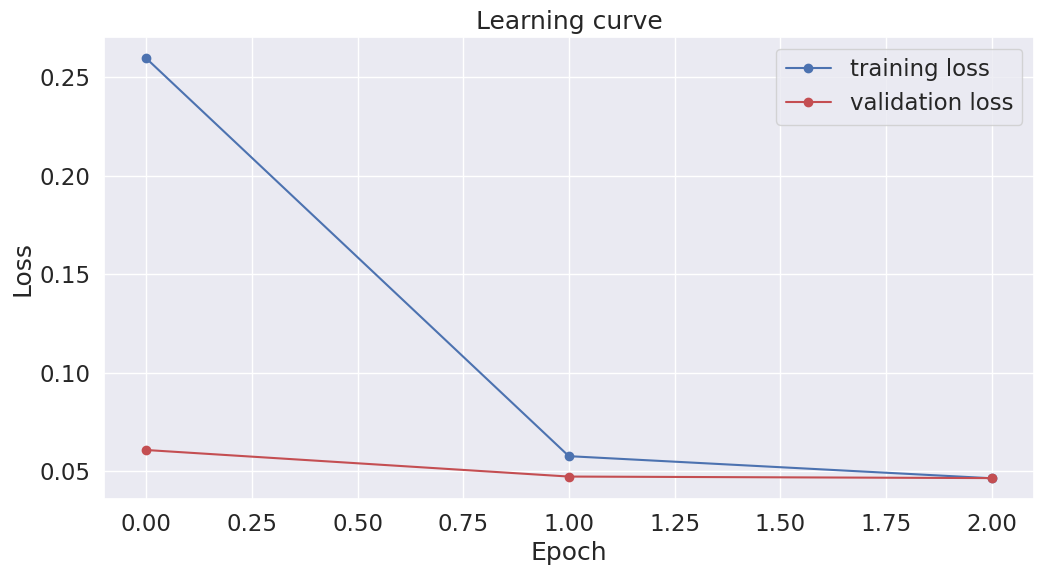

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Test fine-tuned model
Here we pass a string to evaluate how well the NER task has performed.

> *Helen mentioned her husband drinks alcohol once a week and smokes a pack of cigars sometimes daily. He sometimes take illicit drug*






In [90]:
#Test the trained model

tokenized_sentence = tokenizer.encode("Helen mentioned her husband drinks alcohol once a week and smokes a pack of cigars sometimes daily. He sometimes take illicit drug")
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
print(new_tokens)
print(new_labels)
for pair in zip(new_tokens, new_labels):
    print((lambda x, y: f'{x:<20}{y}')(pair[0], pair[1]))

['[CLS]', 'helen', 'mentioned', 'her', 'husband', 'drinks', 'alcohol', 'once', 'a', 'week', 'and', 'smokes', 'a', 'pack', 'of', 'cigars', 'sometimes', 'daily', '.', 'he', 'sometimes', 'take', 'illicit', 'drug', '[SEP]']
['O', 'O', 'O', 'O', 'B-sdoh_community', 'O', 'B-behavior_alcohol', 'O', 'O', 'O', 'O', 'B-behavior_tobacco', 'O', 'B-behavior_tobacco', 'O', 'B-behavior_tobacco', 'O', 'O', 'O', 'O', 'O', 'O', 'B-behavior_drug', 'B-behavior_drug', 'O']
[CLS]               O
helen               O
mentioned           O
her                 O
husband             B-sdoh_community
drinks              O
alcohol             B-behavior_alcohol
once                O
a                   O
week                O
and                 O
smokes              B-behavior_tobacco
a                   O
pack                B-behavior_tobacco
of                  O
cigars              B-behavior_tobacco
sometimes           O
daily               O
.                   O
he                  O
sometimes           